In [4]:
# Operating System functionality, especially for traversing directory structures
import os
# Specialized container datatypes, i.e. specialized versions of lists, dictionaries, etc.
import collections as coll
# Date and time functions, useful for timestamping file names of figures.
import datetime
# Functional programming tools.
import itertools as itt
# Pretty-printing text by wrapping and filling lines.
import textwrap as tw

# Well-known package for n-dimensional arrays, numerical functions, linear algebra, etc.
import numpy as np
# Data analysis package.
import pandas as pd
# "Default" plotting package of Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
# Matplotlib colours module.
import matplotlib.colors as mpcol
# Package improving Matplotlib's default plot style.
import seaborn as sns

# Single Cell Analysis in Python
import scanpy as sc

In [5]:
%run From_Sara/scanpy_aid.py

In [6]:
input_path = 'From_Sara/replicate_2/filtered_feature_bc_matrix/'
data_r2 = read_piriform_adult(input_path)

input_path = 'From_Sara/replicate_3/filtered_feature_bc_matrix/'
data_r3 = read_piriform_adult(input_path)

# Pooling the two replicates
fulldata = data_r2.concatenate(data_r3)

# And verifying if all went well by looking at the dimensions
print(data_r2)
print(data_r3)
print(fulldata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 310 × 31053 
AnnData object with n_obs × n_vars = 198 × 31053 
AnnData object with n_obs × n_vars = 508 × 31053 
    obs: 'batch'


In [9]:
#Filtering our everything that is not Neun positive nuclei
NeuNdata = fulldata[fulldata[:, 'Rbfox3'].X > 0.0]

In [10]:
#Filtering our everything that is not Vglut1 positive from Neun positive nuclei
data = NeuNdata[NeuNdata[:, 'Slc17a7'].X > 0.0]

KeyError: 'Slc17a7'

In [ ]:
import collections as coll

# Print all genes that are present more than once as (name: found x times)
tw.wrap(", ".join("{0}: {1}".format(name, ndup) 
            for name, ndup in coll.Counter(data.var_names).most_common(56)), 70)

In [ ]:
# Add '-1', '-2' etc. to names to make them unique
data.var_names_make_unique()

In [ ]:
# Set the cut-off
MITO_CUTOFF = 0.01

mito_genes = [name for name in data.var_names if name.startswith('mt-')]
# For each cell compute fraction of counts in mito genes vs. all genes.
# The `.A1` is only necessary because X is sparse. It transforms to a 
# dense array after summing
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1

# Add the total counts per cell as observations-annotation to data
data.obs['n_counts'] = data.X.sum(axis=1).A1

# Computing how many genes are expressed in each cell
data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1

# Computing in how many cells a gene is found
data.var['n_cells'] = np.sum(data.X > 0, axis=0).A1

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7.5))

# Global view
sc.pl.scatter(data, x='n_counts', y='percent_mito', show=False, ax=axs[0, 0])
sc.pl.scatter(data, x='n_genes', y='percent_mito', show=False, ax=axs[0, 1]);
sc.pl.scatter(data, x='n_counts', y='n_genes', show=False, ax=axs[0, 2])

# Add a horizontal line at the mito percent cut-off
axs[0, 0].axhline(y=MITO_CUTOFF)
axs[0, 1].axhline(y=MITO_CUTOFF)

# Zoom in on cut-off
sc.pl.scatter(data, x='n_counts', y='percent_mito', show=False, ax=axs[1, 0])
sc.pl.scatter(data, x='n_genes', y='percent_mito', show=False, ax=axs[1, 1]);

axs[1, 0].set_ylim([0.0, 0.15])
axs[1, 1].set_ylim([0.0, 0.15])
# Add a horizontal line again
axs[1, 0].axhline(y=MITO_CUTOFF)
axs[1, 1].axhline(y=MITO_CUTOFF)

In [ ]:
# How many cells do we classify as dying?
n_dying = np.sum(data.obs['percent_mito'] >= MITO_CUTOFF)
n_alive = np.sum(data.obs['percent_mito'] < MITO_CUTOFF)

print("Dying: {}\nAlive: {}".format(n_dying, n_alive))

In [ ]:
# We remove cells that have a high fraction of mito genes, as that marks dead/dying cells.
data = data[data.obs['percent_mito'] < MITO_CUTOFF, :]

In [ ]:
# Parsing transcription factor gene names from http://genome.gsc.riken.jp/TFdb/tf_list.html
def known_transcription_factors():
    infname = '/Users/szeppill/Desktop/analysis_seq/mm_transcription_factors-mm_tf_list.html'
    with open(infname) as infile:
        return set([line.split('<td')[3][1:-5] for line in infile if line.startswith('<tr>')])
    
TFs = known_transcription_factors()
transfac_genes = [name for name in data.var_names if name in TFs]

In [ ]:
# And which are the most expressed transcription factors?
top = 30

# maxs = data[:, transfac_genes].X.max(axis=0).toarray()[0]
maxs = data[:, transfac_genes].X.sum(axis=0).A1
indices = np.argpartition(maxs, kth=len(maxs)-top)[-top:]
most_expressed_tfs = data[:, transfac_genes].var_names[indices].sort_values().tolist()
most_expressed_tfs

In [ ]:
data = normalize(data)

In [ ]:
n_bins = 50
result = filter_by_expr_dispersion(data, n_bins, dry_run=True)

In [ ]:
data = filter_by_expr_dispersion(data, n_bins, dry_run=False)

In [ ]:
# data = regress_and_scale(data)
sc.pp.scale(data)

In [ ]:
sc.tl.pca(data, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(data, log=True, save=True)


In [ ]:
pcs_used, nbs, seed = 2, 15, 6
data, fig, ax = calc_and_plot_graph(data, pcs_used, nbs, seed);
fig.savefig('./figures/pca_clustering.png')

In [ ]:
#Looking at main cell types markers and PCX layers markers
plot_expression_on_graph(data, 
    ['Rbfox3', 'Map2', 'Slc17a8','Gad2','Slc17a7','Slc17a6', 'Mbp', 'Mog', 'Gfap', 'Syn', 'Tbr2', 'Tbr1', 'Rorb', 'Tmem119', 'Siglech', 'Pdgfra','Dcx', 'Bcl11a', 'Bcl11b', 'Tle3', 'Cux1' , 'Sox9', 'Barhl1', 'Satb2','Nr2f1', 'Mef2c','Foxp2', 'Nfia', 'Couptf1' , 'Reln','Pvalb', 'Sst', 'fezf2' , 'Pou3f2' ], columns=3)

In [ ]:
#Looking at layer 1 genes from diodato
plot_expression_on_graph(data, 
    ['Lrp4', 'Fgfr2', 'Prrx1','Zic1','Zic4','Robo4', 'Id4', 'Id1', 'Nrp1', 'Cdh1', 'Id2', 'Prdm6' ], columns=3)

In [ ]:
#Looking at layer 2 genes from diodato
plot_expression_on_graph(data, 
    ['Slit3', 'Penk', 'Slit1','Neurod2','Neurod6','Npcd', 'Trhr', 'Neurod1', 'Epha7', 'Dlk2', 'Ar', 'Nrp2', 'Lmo3' ], columns=3)

In [ ]:
#Looking at layer 3 genes from diodato
plot_expression_on_graph(data, 
    ['Sema3a', 'Prdm8', 'Dpf1','Rxfp1','Rfx4', 'Lhx6', 'Cux2', 'Cart', 'Lhx2' ], columns=3)

In [ ]:
data.obs['louvain'].cat.categories = [
    "0:3", "1:2a/2b", "2:2a", 
    "3:IN", "4:2b"]

In [ ]:
plot_louvain_clusters(data)

In [ ]:
sc.tl.rank_genes_groups(data, 'louvain')
preselected_clustering_names_top = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(30)
preselected_clustering_names_top.to_csv('preselected_clustering_names_top.csv')

In [ ]:
sc.tl.rank_genes_groups(data, 'louvain')
preselected_clustering_names = pd.DataFrame(data.uns['rank_genes_groups']['names'])
preselected_clustering_names.to_csv('preselected_clustering_names_all.csv')

In [ ]:
sc.tl.rank_genes_groups(data, 'louvain')
preselected_clustering_scores_top = pd.DataFrame(data.uns['rank_genes_groups']['scores']).head(30)
preselected_clustering_scores_top.to_csv('preselected_clustering_scores_top.csv')

In [ ]:
sc.tl.rank_genes_groups(data, 'louvain')
preselected_clustering_scores = pd.DataFrame(data.uns['rank_genes_groups']['scores'])
preselected_clustering_scores.to_csv('preselected_clustering_scores_all.csv')

In [86]:
#sc.tl.rank_genes_groups(data, 'louvain', method='t-test')
sc.tl.rank_genes_groups(data, 'louvain', method='logreg')

ranking genes
    consider 'louvain' groups:
    with sizes: [24 22 21 20 17]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:00)


/Users/szeppill/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/szeppill/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [87]:
top = 20
sc.pl.rank_genes_groups(data, n_genes=top, sharey=False)

In [193]:
sc.tl.rank_genes_groups(data, 'louvain', n_genes=len(data.var_names))
neuron_ranking_genes = pd.DataFrame(data.uns['rank_genes_groups']['names'])[[
   "0:3", "1:2a/2b", "2:2a", 
    "3:IN", "4:2b"]]

# Top transcription factors in different piriform neuronal clusters
top = 30
result = []
for colname, ranking in neuron_ranking_genes.iteritems():
    result.append(pd.Series([gname for gname in ranking if gname in transfac_genes]))
pd.concat(result, axis=1)[:top]

ranking genes
    consider 'louvain' groups:
    with sizes: [24 22 21 20 17]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


0         1         2        3         4
0      Rfx3    Thrap3      Rora     Nfia      Ptma
1      Tle1      Egr3     Hdac9   Btbd11     Deaf1
2     Tcf20     Baz1a      Rorb     Sox2     Hesx1
3      Cdk7      Cbx3    Elavl2    Zfp57      Hsf2
4      Thra     Nr4a1      Egr1     Pbx3      Lhx2
5     Fmnl2     Tfdp2      Sox5   Zfp423     Gabpa
6     Myt1l      Mtf2     Camk4  Irf2bp1     Shprh
7   Smarca2   Ppp1r10      Ank2    Glis1    Polr2k
8     Mapk1    Hivep2     Foxo1     Nfib     Rnps1
9       Fus      Mynn    Bcl11a    Nr2e1   Sec14l2
10   Cdkn2d  Gtf2ird1     Nr4a1    Prox1      Fhl2
11    Zfpm2      Ccnk      Ell2     Ldb2      E2f3
12    Mef2d       Tbp      Tcf4     Hes1      Ing3
13    Ccnt2     Nr4a3    Srebf2     Rem2   Zfp354c
14   Zfp146      Junb      Per1     Sox1  BC024063
15      Fah      Elf2     Gtf2i    Aebp1    Tcerg1
16     Mxi1      Sox4    Hmgcs1    Ncoa1    Zfp592
17   Pou2f2    Cited2      Atf5     Rfx2     Pqbp1
18    Trrap    Zdhhc5     Ascl1    Nr2f2     Klf16
19   Zfp277      Xbp1    Pknox2     Hes5     Taf1c
20   Zfp112     Mef2c      Bcl6     Dbx2      Elk3
21    Zfp61     Rabl3      Mkl1     Gli3     Sall2
22   Zfp292      Etv1     Mef2a   Notch2    Polr2j
23      Mpl      Ets2     Mapk8   Notch1     Creb3
24      Mga      Egr2    Zfp148   Notch3     Fem1c
25    Nfat5       Sp2      Mitf    Mef2b      Chd4
26    Phf5a  Ppp1r12c  Gtf2ird1     Rxrg     Nr2f1
27    Mef2c    Arid5b      Klf7     Yaf2     Nptxr
28   Shank3     Hdac5     Hipk2   Gabpb1     Stat6
29     Nfix    Rnf141      Gas7    Usp49     Trp73

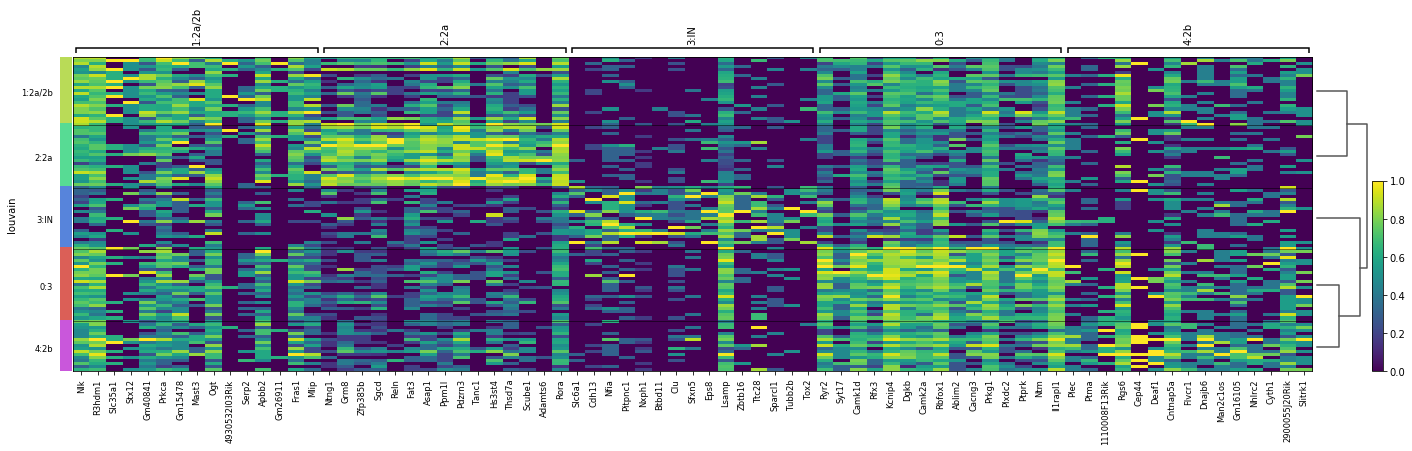

In [175]:
sc.pl.rank_genes_groups_heatmap(data, n_genes=15, standard_scale='var', show_gene_labels=True)

In [94]:
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

(0.0, 5.0)


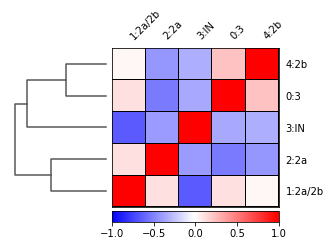

In [95]:
ax = sc.pl.correlation_matrix(data, 'louvain')

In [29]:
marker_genes = ['Gfap','Rbfox3','Gad2','Slc17a7','Tmem119', 'Pdgfra', 'Mbp', 'Mog']

In [96]:
marker_genes2a = ['Rbfox3','Gad2','Slc17a7','Reln', 'Ntng1', 'Tanc1', 'Adamts6', 'Pamr1', 'Col26a1', 'Slc38a3', 'Gdpd5', 'Rcan2', 'Rab3b', 'Rorb']

In [117]:
marker_genesIN = ['Rbfox3','Gad2','Slc17a7','Slc6a1' ,'Cdh13', 'Nxph1', 'Btbd11',  'Tubb2b', 'Tox2',  'Utrn', 'Cemip', 'Sema5a', 'Sox2', 'Pdlim5', 'Stac2', 'Nrip3', 'Ngf', 'Ifi27']

In [176]:
marker_genes3 = ['Rbfox3','Gad2','Slc17a7', 'Kcnip2', 'Gm42722',  'Anapc10', 'Gm28578', 'Tle1', 'Epha4', 'Barhl1']

In [127]:
marker_genes2b = ['Nap1l2','Cep44','Zfp512b','Adam5' , 'Hesx1', 'Gpatch3',  'Gm20721', 'Tmub1',  'C1qa', 'Sac3d1', 'Gm28424']

In [136]:
marker_genes2aAND2b = ['Serp2','Gm26911','Dus3l' , 'Mei1', 'Zbtb49',  'Kin', 'Sept1',  'Hat1', 'Adap2os', 'Antxr1', 'Egr3', 'Fads3', 'Slx4']

In [188]:
marker_genes = ['Rbfox3','Gad2','Slc17a7','Mei1', 'Sept1',   'Adap2os',  'Egr3',  'Slx4','Reln', 'Ntng1', 'Adamts6', 'Slc38a3', 'Gdpd5', 'Rorb','Slc6a1' , 'Nxph1',  'Tubb2b',  'Sema5a', 'Ifi27','Kcnip2', 'Gm42722',   'Gm28578', 'Epha4', 'Barhl1',  'Cep44','Zfp512b','Adam5' , 'Gpatch3',  'Gm28424' ,  ]

In [205]:
marker_genesAssunta = [   'Sema3a',  'Prdm8',  'Cux2' ]

In [206]:
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

In [207]:
ax = sc.pl.stacked_violin(data, marker_genes, groupby='louvain', swap_axes=True,
                         var_group_positions=[(7, 8)], var_group_labels=['neurons'], dendrogram=True)

categories: 0:3, 1:2a/2b, 2:2a, etc.
var_group_labels: neurons


In [192]:
sc.pl.heatmap(data, var_names=marker_genes, groupby='louvain')

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 8.7, 0, 0.2])

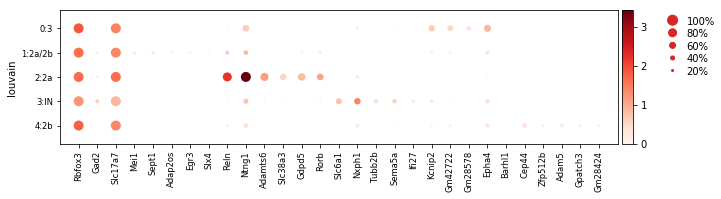

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.149999999999999, 0, 0.2, 0.5, 0.25])

In [191]:
sc.pl.dotplot(data, var_names=marker_genes, groupby='louvain')

categories: 0:3, 1:2a/2b, 2:2a, etc.
var_group_labels: neurons


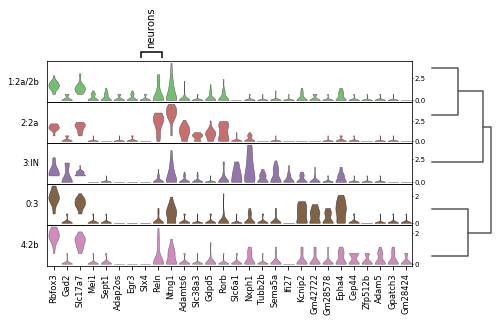

In [157]:
ax = sc.pl.stacked_violin(data, marker_genes, groupby='louvain', 
                         var_group_positions=[(7, 8)], var_group_labels=['neurons'], dendrogram=True)